<h1>Análisis de los programas políticos para las Elecciones Generales en España (28 de abril, 2019)<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Motivación" data-toc-modified-id="Motivación-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Motivación</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Carga-de-datos" data-toc-modified-id="Carga-de-datos-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Carga de datos</a></span><ul class="toc-item"><li><span><a href="#Fuentes-de-datos" data-toc-modified-id="Fuentes-de-datos-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Fuentes de datos</a></span></li><li><span><a href="#Funciones-para-web-scrapping" data-toc-modified-id="Funciones-para-web-scrapping-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Funciones para web scrapping</a></span></li><li><span><a href="#Funciones-para-parseo-de-PDF" data-toc-modified-id="Funciones-para-parseo-de-PDF-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Funciones para parseo de PDF</a></span></li><li><span><a href="#Funciones-para-parseo-de-Excel" data-toc-modified-id="Funciones-para-parseo-de-Excel-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Funciones para parseo de Excel</a></span></li><li><span><a href="#Control-de-la-carga" data-toc-modified-id="Control-de-la-carga-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Control de la carga</a></span></li></ul></li><li><span><a href="#Obtención-y-preprocesamiento-del-texto" data-toc-modified-id="Obtención-y-preprocesamiento-del-texto-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Obtención y preprocesamiento del texto</a></span><ul class="toc-item"><li><span><a href="#Palabras-vacías" data-toc-modified-id="Palabras-vacías-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Palabras vacías</a></span></li></ul></li><li><span><a href="#Nubes-de-palabras" data-toc-modified-id="Nubes-de-palabras-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Nubes de palabras</a></span><ul class="toc-item"><li><span><a href="#Nubes-de-palabras-por-frecuencia" data-toc-modified-id="Nubes-de-palabras-por-frecuencia-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Nubes de palabras por frecuencia</a></span></li></ul></li><li><span><a href="#Preocupaciones-de-los-españoles" data-toc-modified-id="Preocupaciones-de-los-españoles-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Preocupaciones de los españoles</a></span><ul class="toc-item"><li><span><a href="#Encuesta-del-CIS" data-toc-modified-id="Encuesta-del-CIS-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Encuesta del CIS</a></span></li><li><span><a href="#Reflejo-en-los-programas-electorales" data-toc-modified-id="Reflejo-en-los-programas-electorales-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Reflejo en los programas electorales</a></span></li></ul></li><li><span><a href="#Otros-temas-sensibles" data-toc-modified-id="Otros-temas-sensibles-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Otros temas sensibles</a></span></li><li><span><a href="#Líneas-futuras-de-trabajo" data-toc-modified-id="Líneas-futuras-de-trabajo-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Líneas futuras de trabajo</a></span></li><li><span><a href="#Referencias" data-toc-modified-id="Referencias-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Referencias</a></span></li></ul></div>

# Motivación

Estamos en los últimos días de la campaña electoral previa a las Elecciones Generales en España, y los partidos políticos tratan de convencer a los no pocos indecisos, usando todas sus armas. Si nos apartamos de los debates, de los mítines en grandes recintos, de los mensajes lanzados en redes sociales, y de las entrevistas concedidas a los medios, nos quedamos con lo que debería ser lo más importante: sus programas.

En este notebook vamos a analizar algunos aspectos de los programas electorales de los principales partidos políticos españoles (en cuanto a intención de voto, según las últimas encuestas realizadas).

NOTA: Por aquí nadie se ha leído ningún programa.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import string
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multidict as multidict
import plotly_express as px
import nltk

from bs4 import BeautifulSoup as bso
from os import path
from tika import parser, config
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from stop_words import get_stop_words

In [3]:
%matplotlib inline
sns.set()

# Carga de datos

## Fuentes de datos

**Programas electorales**:
* [PSOE](https://www.psoe.es/programa-electoral/) (completo, pdf)
* [Ciudadanos](https://www.ciudadanos-cs.org/programa-electoral) (completo, web)
* [PP](https://www.pp.es/conocenos/programas) (completo, pdf)
* [Vox](https://www.voxespana.es/espana/programa-electoral) (*"completo"*, pdf)
* [Unidas Podemos](https://podemos.info/programa/) (completo, pdf)

**Datos del [CIS](http://www.analisis.cis.es/cisdb.jsp)**:
* Problemas_principales_que_existen_actualmente_en_Espana_3_ordinal.xls
* Problemas_sociales_que_personalmente_afectan_mas_3_ordinal.xls

In [4]:
# Programs
program_path = 'data/full/'
cs_web = 'https://www.ciudadanos-cs.org/programa-electoral'

# Logos
logo_path = 'img/logos/'

## Funciones para web scrapping

Funciones utilizadas para obtener los programas que no están en PDF. Usaremos `BeautifulSoup` para obtener todo el texto de la web correspondiente:

In [5]:
def parse_web_program(party):
    if party == 'ciudadanos':
        raw_txt = parse_cs_program()
        txt_path = program_path + party + '.txt'
        with open(txt_path, 'w') as f:
           f.write(raw_txt)
        return raw_txt
    else:
        raise ValueError('Unknown party: ' + party)

def parse_cs_program():
    html_doc = requests.get(cs_web)
    soup = bso(html_doc.text, 'html.parser')
    raw_txt = []
    
    contents = soup.select('.propuesta')
    for content in contents:
        raw_txt.append(content.select('.titulo')[0].get_text())
        raw_txt.extend([h3.get_text() for h3 in content.select('h3')])
        raw_txt.extend([li.get_text() for li in content.select('li')])
    
    return ' '.join(raw_txt)

## Funciones para parseo de PDF

Para obtener el texto de los PDFs usaremos el comando `pdftotext`; después de haber probado `tika` y `textract` con peores resultados:

In [6]:
def parse_pdf_program(party, first=1):
    pdf_path = program_path + party + '.pdf'
    txt_path = program_path + party + '.txt'

    !pdftotext -f $first -nopgbrk $pdf_path

    return str(parser.from_file(txt_path)['content'])

## Funciones para parseo de Excel

Para parsear los ficheros Excel obtenidos de la web de CIS usaremos directamente `pandas`:

In [7]:
cis_xls = f'data/cis/Problemas_principales_que_existen_actualmente_en_Espana_3_ordinal.xls'
cis_xls2 = f'data/cis/Problemas_sociales_que_personalmente_afectan_mas_3_ordinal.xls'

def parse_cis_excel():
    df = pd.read_excel(cis_xls, skiprows=6, usecols=[0, 4], nrows=42)
    df.columns = ['problem', 'concern']
    return df.sort_values(by='concern', ascending=False)

## Control de la carga

Función para obtener el programa electoral dependiendo de cada partido:

In [8]:
def get_program(party):
    party = party.lower()
    if party == 'ciudadanos':
        return parse_web_program('ciudadanos')
    elif party == 'psoe':
        return parse_pdf_program('psoe', 8)
    elif party == 'unidas_podemos':
        return parse_pdf_program('unidas_podemos', 5)
    elif party == 'pp':
        return parse_pdf_program('pp', 6)
    elif party == 'vox':
        return parse_pdf_program('vox', 1)
    else:
        raise NotImplementedError('Party not found: ' + party)

Aquí es donde controlaremos los partidos a comparar:

In [9]:
parties = ['pp', 'ciudadanos', 'vox', 'psoe', 'unidas_podemos']

# Obtención y preprocesamiento del texto

Creamos funciones para preprocesar el texto, con el fin de:
* eliminar los caracteres que nos sobran
* pasar todo a minúsculas
* aplicar word lemmatization + stemming (en pruebas)

NOTA: Más adelante eliminaremos los signos de puntuación.

In [10]:
def simple_stemmer(text):
    #stemmer = nltk.porter.PorterStemmer()
    stemmer = nltk.stem.SnowballStemmer('spanish')
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

In [11]:
def preprocess_raw_text(raw_txt):
    fix_txt = raw_txt.replace('\r\n', '').lower()
    #fix_txt = simple_stemmer(raw_txt.replace('\r\n', '').lower())
    #print(fix_txt)
    return fix_txt

Obtenemos el texto de los programas de todos los partidos y lo preprocesamos:

In [12]:
programs_dict = {party: preprocess_raw_text(get_program(party)) for party in parties}

## Palabras vacías

Como estamos procesando lenguaje natural (aunque sea jerga política) tendremos algunas palabras que se repiten mucho, como en cualquier texto de cualquier tipo, y que no aportan mucha información; son las conocidas como palabras *vacías*. Ejemplo: pronombres, preposiciones, conjunciones, etc. La idea es quitar todas estas palabras para que no interfieran en nuestro análisis.

Vamos a utilizar una lista ya existente en la librería `stop-words`:

In [13]:
stopwords = get_stop_words('es')
print(stopwords)

['a', 'al', 'algo', 'algunas', 'algunos', 'ante', 'antes', 'como', 'con', 'contra', 'cual', 'cuando', 'de', 'del', 'desde', 'donde', 'durante', 'e', 'el', 'ella', 'ellas', 'ellos', 'en', 'entre', 'era', 'erais', 'eran', 'eras', 'eres', 'es', 'esa', 'esas', 'ese', 'eso', 'esos', 'esta', 'estaba', 'estabais', 'estaban', 'estabas', 'estad', 'estada', 'estadas', 'estado', 'estados', 'estamos', 'estando', 'estar', 'estaremos', 'estará', 'estarán', 'estarás', 'estaré', 'estaréis', 'estaría', 'estaríais', 'estaríamos', 'estarían', 'estarías', 'estas', 'este', 'estemos', 'esto', 'estos', 'estoy', 'estuve', 'estuviera', 'estuvierais', 'estuvieran', 'estuvieras', 'estuvieron', 'estuviese', 'estuvieseis', 'estuviesen', 'estuvieses', 'estuvimos', 'estuviste', 'estuvisteis', 'estuviéramos', 'estuviésemos', 'estuvo', 'está', 'estábamos', 'estáis', 'están', 'estás', 'esté', 'estéis', 'estén', 'estés', 'fue', 'fuera', 'fuerais', 'fueran', 'fueras', 'fueron', 'fuese', 'fueseis', 'fuesen', 'fueses', 'fu

Además vamos a añadir algunas palabras más que también aparecen bastante en algún programa y que no aportan mucho semánticamente...

In [14]:
stopwords.extend(['así', 'pág', 'ello', 'año', 'años', 'manera', 'forma', 'cualquier', 
                 'ser', 'cada', 'solo'])

# Nubes de palabras

Vamos a analizar las palabras más utilizadas por cada partido en su programa electoral. Para ello usaremos un recurso muy visual: las nubes de palabras, donde se refleja la frecuencia relativa de las que más veces aparecen.

Usaremos la genial librería `word_cloud` para generar dichas nubes:

In [15]:
def generate_word_cloud(input, party):     
    
    mask = np.array(Image.open(logo_path + party + '.png'))
    
    wc = WordCloud(background_color="white", max_words=300, mask=mask,
                   width=900, height=450, min_font_size=7, max_font_size=100,
                   stopwords=stopwords, collocations=True, normalize_plurals=True,
                   #contour_width=3, contour_color='steelblue', colormap='viridis',
                   prefer_horizontal=1)
    
    if isinstance(input, str):
        wc.generate(input)
    else:
        wc.generate_from_frequencies(input)

    plt.figure(figsize=(15,15))
    plt.imshow(wc.recolor(color_func=ImageColorGenerator(mask)), interpolation="bilinear")
    plt.axis("off")
    #plt.savefig('img/clouds/'+party+'.png', format="png")
    plt.show();
    
    return wc

Podemos crear una nube de palabras dejando todo en manos de la librería word_cloud, que se encargará de signos de puntuación, plurales, bigramas, etc.

In [16]:
wcs = {}
for party in parties[0:0]:
    print(party.upper())
    wcs[party] = generate_word_cloud(programs_dict[party], party)

Con el siguiente código obtendríamos el peso relativo de cada palabra, de mayor a menor importancia:

In [17]:
for party in parties[0:0]:
    print(party.upper())
    wcs[party].words_

NOTA: No hay resultado porque los bucles están *desactivados*. Después de realizar varias pruebas y comprobaciones con este modo, resulta más indicado usar otra variante, para poder controlar un poco más el proceso y no obtener cosas raras...

## Nubes de palabras por frecuencia

Vamos a crear las nubes de palabras sin dejar todo en manos de la librería word_cloud. Para cada programa electoral primero crearemos un diccionario con todas las palabras y el número de apariciones de cada una, de tal forma que podamos usarlo más adelante para seguir analizando esos datos.

Adicionalmente imprimiremos el número de apariciones de las 50 palabras más frecuentes en cada programa electoral.

NOTA: En este punto eliminamos signos de puntuación (para evitar por ejemplo tener palabras que incluyan puntos o comas). También quitamos palabras con menos de 3 caracteres.

In [18]:
# Punctuation signs
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [19]:
def get_frequency_dict(input_txt):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # Missing '+'? expecting 'I+D'...
    clr_txt = input_txt.translate(str.maketrans('!"#$%&\'()*,-./:;<=>?@[\\]^_`{|}~',
                                                '                               '))
    # making dict for counting frequencies
    for word in clr_txt.split(' '):
        if word not in stopwords and len(word) > 2:
            tmpDict[word] = tmpDict.get(word, 0) + 1

    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    
    return fullTermsDict

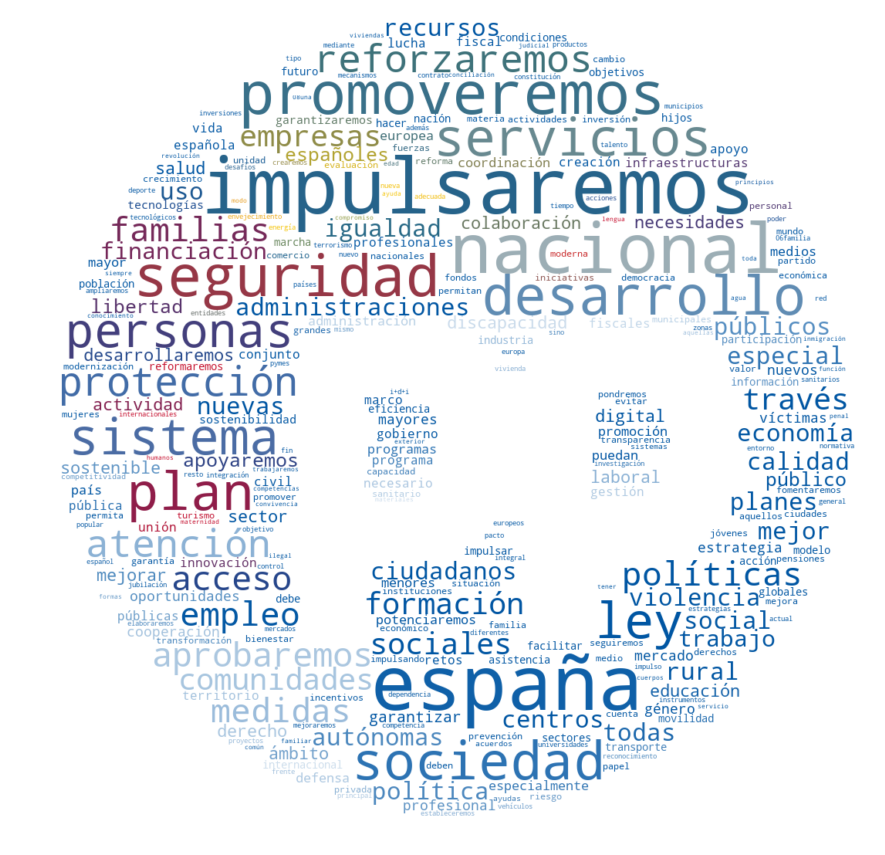

PP
impulsaremos: 95 | españa: 94 | nacional: 76 | promoveremos: 76 | seguridad: 71 | desarrollo: 64 | sociedad: 60 | plan: 60 | servicios: 58 | sistema: 55 | ley: 54 | personas: 49 | protección: 49 | reforzaremos: 47 | atención: 47 | aprobaremos: 46 | acceso: 46 | medidas: 44 | políticas: 44 | empleo: 43 | familias: 43 | comunidades: 42 | formación: 41 | empresas: 40 | sociales: 40 | través: 39 | administraciones: 39 | política: 38 | especial: 38 | planes: 38 | públicos: 37 | recursos: 37 | uso: 37 | centros: 37 | igualdad: 36 | autónomas: 36 | nuevas: 35 | mejor: 34 | rural: 34 | todas: 34 | violencia: 34 | ciudadanos: 33 | calidad: 32 | social: 32 | economía: 32 | trabajo: 31 | financiación: 31 | apoyaremos: 31 | españoles: 30 | libertad: 30 | 

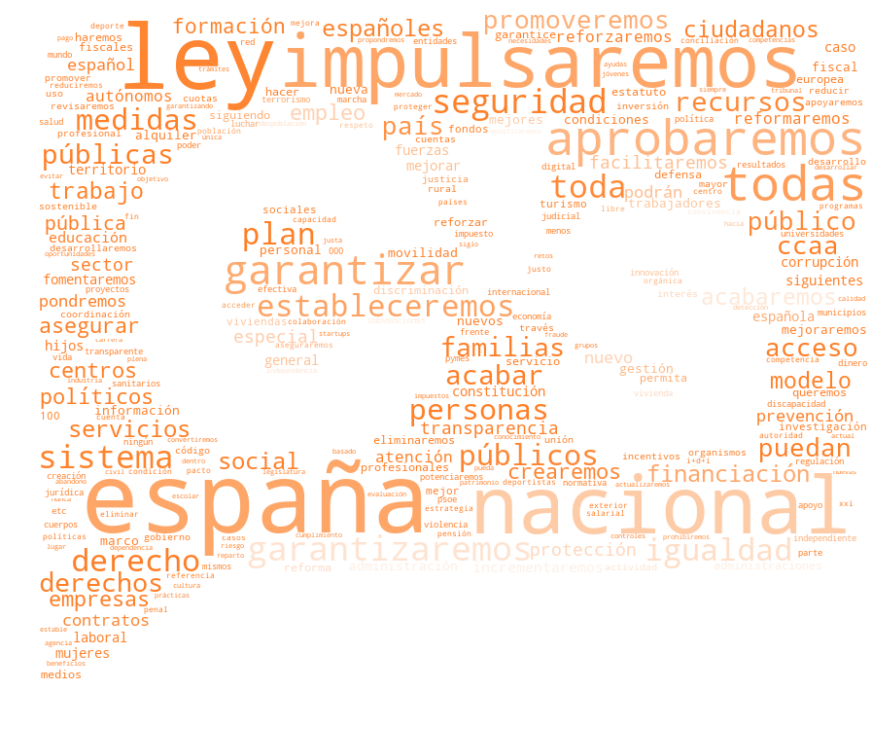

CIUDADANOS
españa: 72 | ley: 60 | nacional: 47 | impulsaremos: 39 | aprobaremos: 35 | todas: 35 | garantizar: 33 | garantizaremos: 30 | seguridad: 29 | toda: 28 | sistema: 28 | igualdad: 27 | derecho: 27 | estableceremos: 26 | plan: 26 | públicos: 25 | medidas: 25 | personas: 25 | públicas: 22 | recursos: 22 | acabar: 22 | derechos: 21 | familias: 21 | público: 20 | puedan: 20 | ccaa: 20 | acceso: 20 | país: 20 | promoveremos: 20 | financiación: 19 | españoles: 19 | servicios: 19 | social: 19 | ciudadanos: 18 | modelo: 18 | acabaremos: 18 | trabajo: 18 | asegurar: 17 | políticos: 17 | empleo: 17 | crearemos: 17 | empresas: 17 | centros: 17 | formación: 16 | pública: 15 | transparencia: 15 | protección: 15 | sector: 15 | especial: 15 | facilitaremos: 15 | 

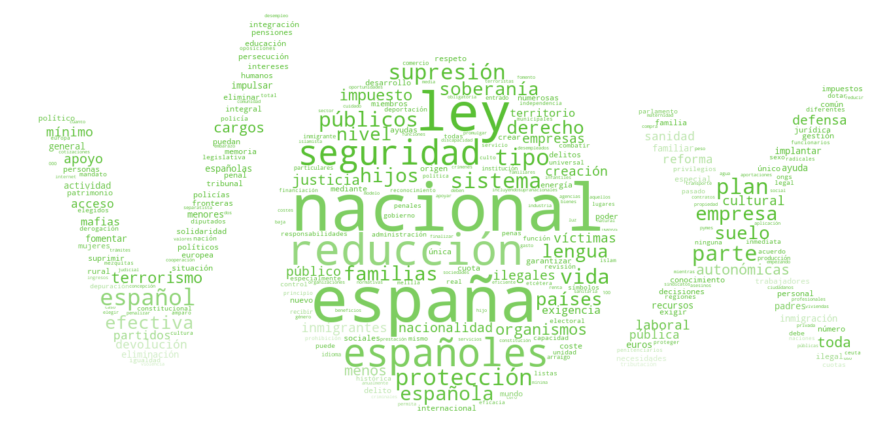

VOX
nacional: 16 | españa: 15 | ley: 10 | reducción: 9 | españoles: 8 | seguridad: 8 | protección: 7 | español: 7 | tipo: 7 | supresión: 7 | plan: 7 | sistema: 7 | parte: 7 | públicos: 7 | vida: 7 | española: 7 | empresa: 7 | familias: 7 | hijos: 7 | soberanía: 6 | lengua: 6 | derecho: 6 | efectiva: 6 | países: 6 | nivel: 6 | suelo: 6 | organismos: 6 | impuesto: 6 | terrorismo: 6 | menos: 5 | autonómicas: 5 | toda: 5 | justicia: 5 | cargos: 5 | inmigrantes: 5 | ilegales: 5 | empresas: 5 | nacionalidad: 5 | víctimas: 5 | defensa: 5 | público: 5 | mínimo: 5 | apoyo: 5 | laboral: 5 | creación: 5 | cultural: 5 | partidos: 4 | acceso: 4 | pública: 4 | devolución: 4 | 

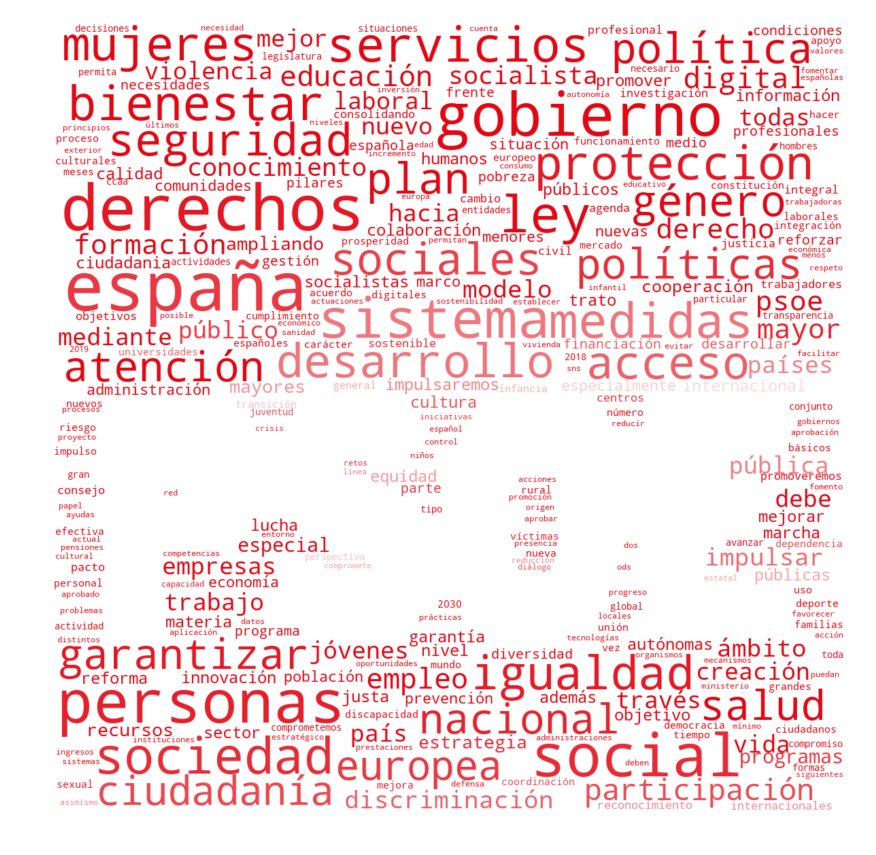

PSOE
españa: 242 | derechos: 212 | gobierno: 186 | personas: 184 | social: 179 | sistema: 156 | ley: 133 | sociedad: 130 | medidas: 120 | servicios: 120 | bienestar: 118 | igualdad: 116 | protección: 116 | mujeres: 115 | desarrollo: 111 | acceso: 109 | seguridad: 106 | sociales: 103 | género: 97 | plan: 97 | políticas: 95 | política: 94 | garantizar: 94 | nacional: 90 | atención: 89 | salud: 88 | ciudadanía: 85 | europea: 84 | participación: 82 | digital: 79 | empleo: 77 | educación: 77 | formación: 75 | psoe: 74 | mayor: 73 | derecho: 72 | conocimiento: 72 | socialista: 71 | impulsar: 69 | ámbito: 68 | modelo: 67 | discriminación: 67 | hacia: 65 | empresas: 64 | creación: 64 | vida: 63 | todas: 62 | trabajo: 62 | jóvenes: 61 | violencia: 61 | 

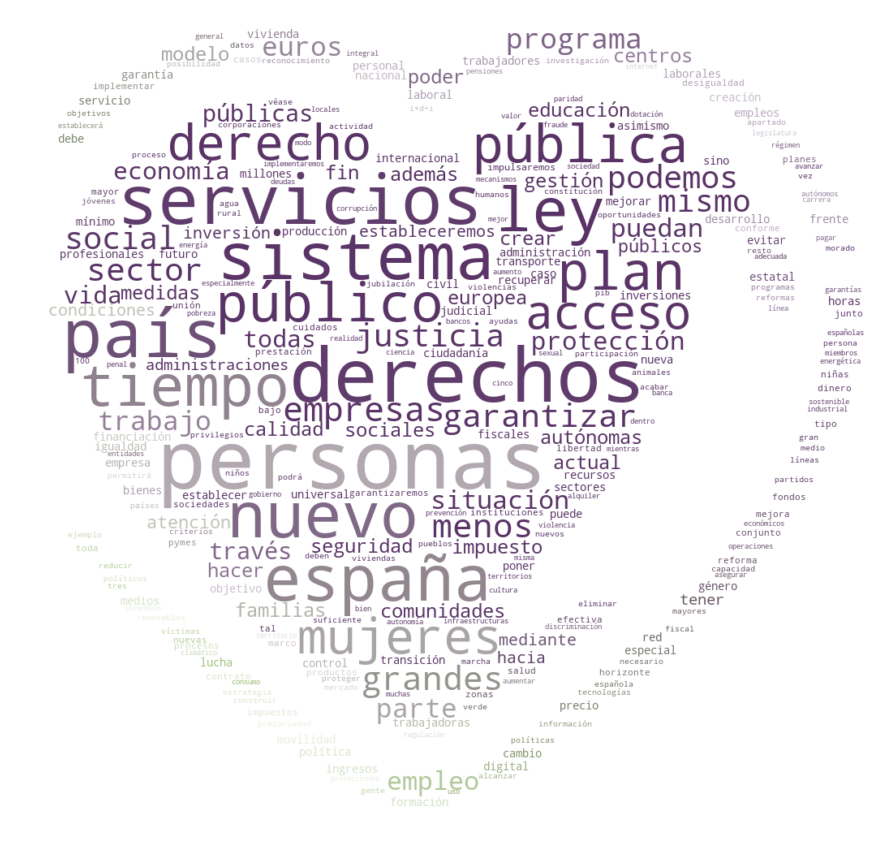

UNIDAS_PODEMOS
personas: 93 | derechos: 78 | servicios: 64 | país: 61 | sistema: 60 | nuevo: 56 | españa: 56 | ley: 52 | tiempo: 47 | público: 44 | plan: 43 | pública: 42 | mujeres: 41 | derecho: 41 | acceso: 40 | empresas: 40 | grandes: 39 | menos: 39 | sector: 38 | garantizar: 38 | podemos: 36 | justicia: 36 | social: 36 | mismo: 34 | programa: 34 | parte: 31 | euros: 31 | trabajo: 31 | empleo: 30 | situación: 30 | puedan: 30 | protección: 30 | vida: 29 | todas: 29 | economía: 29 | públicas: 29 | través: 28 | comunidades: 28 | hacer: 28 | impuesto: 28 | fin: 27 | sociales: 27 | autónomas: 27 | seguridad: 27 | modelo: 26 | poder: 26 | actual: 26 | europea: 26 | educación: 26 | medidas: 25 | 

In [20]:
freq_dicts = {}
wcs = {}

for party in parties:
    
    # Generate frequencies dict
    freq_dicts[party] = get_frequency_dict(programs_dict[party])

    # Generate word cloud. NOTE: neither bigrams nor normalization with this approach
    wcs[party] = generate_word_cloud(freq_dicts[party], party)
    
    # Print Top 50 words with frequency
    print(party.upper())
    for key in sorted(freq_dicts[party], key=freq_dicts[party].get, reverse=True)[:50]:
        print('{}: {}'.format(key, freq_dicts[party][key]), end=' | ')
    

**¿Es lo que esperabas?**

Con ésto podríamos intentar hacernos una idea de los temas más importantes en cada programa. A poco que conozcas de qué pie cojea cada partido, comprobarás que gracias a la nube de palabras del programa estamos obteniendo una pequeña radiografía del partido.

Quizá para incidir más en las diferencias podríamos prescindir de palabras comunes como *España*, ya que es normal que aparezca mucho estando donde estamos. Pero para el análisis completo resulta interesante conservar todo. ¿O no resulta curioso ver que Unidas Podemos tiene el único programa donde *España* no aparece en el Top 2? Igual es porque ellas usan la palabra *país* con tanta frecuencia como la anterior. Posiblemente no esperabas que el PSOE usaría la palabra *España* más que los partidos de derecha. ¡Tranquilidad! esos partidos tienen otras palabras como *nacional* para que su identidad quede clara.

¡Pues sí que ha dado juego una palabra que pensábamos que no aportaba nada! te invito a que busques palabras más interesantes como *derechos*, *ley*, *sanidad*, *educación*, *impuestos*, *empleo*, *corrupción*, ....

¿Y qué pasa con las que podemos echar de menos? vamos a intentar responder a esa pregunta en el siguiente punto.

# Preocupaciones de los españoles

¿Cuál es la labor de los partidos políticos? Es una buena pregunta. Supuestamente, los partidos intentan representar a la mayor cantidad posible de ciudadanos, y en teoría los programas electorales deberían intentar recoger soluciones a los problemas más importantes; tanto de la mayoría, como de las múltiples minorías. Bueno... sabiendo que los partidos más grandes se van a centrar en el interés general (de verdad que lo siento por esas minorías), su programa debería reflejar de manera especial cuáles son sus propuestas para las mayores preocupaciones del votante medio. ¿O no?

El **CIS** (Centro de Investigaciones Sociológicas) realiza mensualmente una encuesta donde pregunta a una pequeña muestra de la población cuáles son los 3 problemas que más preocupan, y ofrece los resultados de forma abierta; lo que nos sirve para hacernos una idea del sentimiento general. Parece un buen punto de partida....

Vamos a intentar averiguar si la prioridad que dan a estos temas los programas electorales se corresponde con la importancia que le dan los votantes.

## Encuesta del CIS

Cargamos los datos del CIS de la última encuesta realizada:

In [21]:
cis_df = parse_cis_excel()

Dibujamos una gráfica interactiva de barras horizontales para visualizar de forma clara los datos, usando `plotly_express`:

In [22]:
px.bar(
    cis_df, x="concern", y="problem", template="plotly_white",
    labels=dict(concern="% de encuestados para los que el problema es Top 3", problem="Problema"),
    width=970, height=800, title="Principales (3) preocupaciones de los españoles [marzo 2019]",
    orientation='h'
)

El paro, la corrupción, el fraude, la clase política, la economía, sanidad, educación, .... Aunque pudiéramos esperar una lista así, siempre es importante conocer las cifras. Según los datos, sólo los 18 principales problemas superan el 1% de personas que los coloca en su Top 3 personal. Aunque está claro que el medioambiente le preocupa a más de un 0,8% de la población, ¿VERDAD?

Vemos que hay mucha diferencia entre el primer problema y el segundo; o entre los 4 primeros y todos los demás. Pues a ver qué dicen los programas electorales...

## Reflejo en los programas electorales

Vamos a crear un diccionario con una entrada para cada uno `(*)` de los principales problemas según la encuesta del CIS. Y para cada entrada hacemos una lista con algunas de las palabras más significativas que esperaríamos encontrar relacionadas con el tema de la entrada en cuestión.

Esta parte es la más delicada, porque hay palabras que podrían relacionarse con varios temas, y habrá que valorar su inclusión en una lista o en otra (o en ninguna). Por ejemplo, seguramente una de las primeras palabras que nos viene a la mente cuando hablamos de *violencia machista* es *género*, pero está claro que también se puede hablar de *género* relacionado simplemente con la *mujer* (desigualdades); ante la duda la dejaremos fuera.

`(*)` NOTA: algunos temas han sido unidos, como por ejemplo *Cataluña* y los *nacionalismos*, *paro* y *calidad del empleo*, o *políticos* e *inestabilidad*. Otros han sido separados, como *fraude* y *corrupción* (¿por qué los une el CIS?). El *terrorismo internacional* ha pasado a ser *terrorismo* en general.

In [23]:
problems = {'empleo': ['paro', 'paradas', 'parados', 'parada', 'parado', 'empleo', 'desempleado',
                       'desempleada', 'desempleados', 'desempleo', 'laboral', 'laborales', 'salario'],
            'corrupción': ['corrupción', 'corrupto', 'corrupta', 'corruptos', 'corruptas', 
                           'imputados', 'imputado'],
            'fraude': ['fraude', 'defraudan', 'defraudar', 'defraudado', 'defraudador', 'defraudadores'],
            'políticos': ['regeneración', 'pacto', 'pactos', 'consenso', 'diálogo', 'casta',
                          'inestabilidad', 'acuerdos', 'desacuerdos'],
            'economía': ['economía', 'pib', 'económica', 'crisis', 'mercado', 'euro', 'económico',
                         'crecimiento'],
            'sanidad': ['sanidad', 'médico', 'médicos', 'quirófano', 'hospital', 'sanitarios', 
                        'sanitarias', 'sanitaria', 'medicamentos'],
            'educación': ['educación', 'enseñanza', 'escuela', 'idiomas', 'profesores', 'guardería',
                          'guarderías', 'universidad', 'universidades'],
            'nacionalismos': ['cataluña', 'catalanes', 'referéndum', '155', 'independencia', 'independentistas', 
                         'nacionalismo', 'nacionalismos', 'separatistas', 'separatismo', 'soberanía'],
            'social': ['social', 'equitativa', 'equitativo', 'sociales', 'pobreza'],
            'pensiones': ['pensiones', 'pensión', 'jubilación', 'pensionistas', 'pensionista', 'jubilado', 
                          'jubilados', 'jubiladas'],
            'inmigración': ['inmigración', 'inmigrante', 'inmigrantes', 'extranjero', 'extranjeros', 
                            'refugiados', 'refugiado', 'cie', 'salvamento', 'frontera', 'ceuta'],
            'violencia_machista': ['machista', 'machistas', 'acoso', 'violación', 'violada', 'violadas', 
                                   'violaciones', 'maltrato', 'maltratada', 'maltratadas'],
            'inseguridad': ['inseguridad', 'ciberataques', 'ciberseguridad', 'policía', 'violentos', 
                            'crímenes', 'robos'],
            'vivienda': ['vivienda', 'alquiler', 'alquileres', 'hipoteca', 'hipotecas', 'especulación', 
                         'especuladores', 'buitre', 'buitres', 'desahucio', 'desahucios', 'okupa', 'okupas'],
            'justicia': ['justicia', 'jueces', 'juez', 'juicio', 'juicios', 'sentencia', 'prisión', 
                         'cárcel', 'tribunal', 'tribunales'],
            'valores': ['valores', 'familia', 'aborto', 'tradiciones', 'tradición'],
            'mujer': ['mujer', 'mujeres', 'feminismo', 'feminismos', 'paridad'],
            'medioambiente': ['medioambiente', 'medioambiental', 'planeta', 'contaminación', 'contaminantes', 
                              'reciclar', 'renovables', 'climático', 'ambiental', 'ambientales'],
            'juventud': ['juvenil', 'juventud', 'jóvenes', 'emancipación'],
            'infraestructuras': ['infraestructura', 'infraestructuras', 'carreteras', 'trenes', 
                                 'ave', 'ferroviaria', 'ferroviarias', 'puentes', 'autopistas', 
                                 'carretera'],
            'impuestos': ['impuestos', 'impuesto', 'iva', 'irpf', 'sucesiones', 'gravamen'],
            'inversión': ['i+d', 'i+d+i', 'inversión', 'inversiones', 'invertir', 'invierte', 'investigación',
                          'investigadores'],
            'monarquía': ['monarquía', 'reyes', 'república', 'rey', 'monarca', 'republicanos'],
            'autónomos': ['autónomos', 'emprendedores', 'emprendedor'],
            'racismo': ['racismo', 'racista', 'racistas', 'xenofobia', 'xenófobo', 'xenófobos'],
            'drogas': ['droga', 'drogas', 'heroína', 'cocaína', 'adicción', 'adicciones'],
            'agropecuario_pesca': ['agrario', 'agraria', 'agricultura', 'agricultor', 'agricultores', 
                                  'ganadería', 'ganadero', 'ganaderos', 'pesca', 'pescadores', 'pescador',
                                  'agropecuario', 'agrícola', 'agrícolas'],
            'terrorismo': ['terrorismo', 'terrorista', 'terroristas', 'isis', 'eta', 'etarra', 'islamista',
                           'islamistas', 'atentado', 'atentados', 'etarras']
            }

Vamos a contar el número de palabras en cada programa electoral (eliminadas palabras vacías y palabras menores de 3 letras). El motivo es que, aparte de contar el número de apariciones de las palabras relacionadas con cada problema, nos interesa saber su frecuencia; de tal forma que podamos ver la importancia relativa dentro de cada programa, y también podamos hacer una comparativa válida entre todos.

In [24]:
program_words = {party: sum(freq_dicts[party].values()) for party in parties}  
program_words

{'pp': 14499,
 'ciudadanos': 7479,
 'vox': 1824,
 'psoe': 33127,
 'unidas_podemos': 14811}

Creamos un dataframe con el conteo de palabras asociadas a cada problema, para cada partido:

In [25]:
def build_problems_df(problems):
    df = pd.DataFrame(columns=problems.keys(), dtype=int)

    for party in parties:
        counts_array = []
        for problem in problems.keys():
            counts = 0
            for word in problems.get(problem):
                counts += freq_dicts[party].get(word, 0)
            counts_array.append(counts)
        df.loc[party] = counts_array

    df['TOTAL'] = program_words.values()
    return df

In [26]:
df = build_problems_df(problems)

Vamos a pintar el contenido del dataframe usando la función `heatmap()` de `seaborn`:

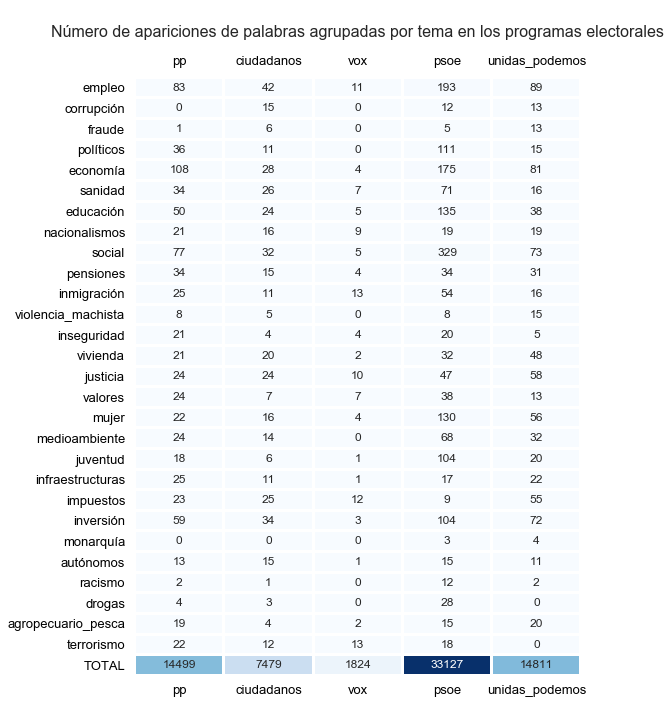

In [27]:
plt.figure(figsize=(8,11))
ax = sns.heatmap(df.T, annot=True, fmt='d', cmap='Blues', cbar=False, linecolor='white', linewidths=2)

ax.tick_params(labelbottom=True, labeltop=True, labelsize=13, labelcolor='black')
ax.set_title('\nNúmero de apariciones de palabras agrupadas por tema en los programas electorales\n\n', 
             fontsize=16);

**¿Algo interesante por aquí?**

Así, de primeras:
* Segunda preocupación de los españoles, cara A: la **corrupción**. Lo más llamativo es que el programa del PP no usa ninguna de estas palabras: 'corrupción', 'corrupto', 'corrupta', 'corruptos', 'corruptas', 'imputados', 'imputado'. En casi 15.000 palabras parece que no había sitio para que el adalid de la regeneración política tocase el tema; curioso cuando supuestamente quieren romper con lo que les ha hecho perder más votos. Tampoco aparece la corrupción en el programa de Vox, lo que resulta aún más preocupante tratándose de un partido nuevo.
* Segunda preocupación, cara B: el **fraude**. El programa del PP usa una única vez alguna de estas palabras: 'fraude', 'defraudan', 'defraudado', 'defraudador', 'defraudadores'. Si vas al programa esto es todo lo que encontrarás sobre el tema: *'Reforzaremos las políticas de lucha contra el fraude fiscal, potenciando el uso de los medios humanos y tecnológicos'*. Vox ni eso. Bravo.
* El **programa de Vox** parece no hablar de otras preocupaciones importantes. Por ejemplo: violencia machista. Buscando en su programa por la palabra *género*, eliminada a propósito de esa categoría, sí que encontramos una promesa electoral relacionada: derogar la ley de violencia de género (¿suponemos que esa ley es la causa de la preocupación?). Y nada de medioambiente. Ya sabíamos que no era un programa electoral al uso, ¿no?

Y después de ver un poco por encima las anomalías (y de asegurarnos de que nuestro código está bien), vamos a pasar de número de apariciones a frecuencias, para poder analizar mejor los resultados. Creamos otro dataframe diviendo ese número de apariciones por el número de palabras total en cada programa (y multiplicando por 100 para obtener porcentajes):

In [28]:
df_rel = df.div(0.01*df['TOTAL'], axis=0).drop('TOTAL', axis=1)

De nuevo usamos el mapa de calor de `seaborn` para representar el contenido del dataframe:

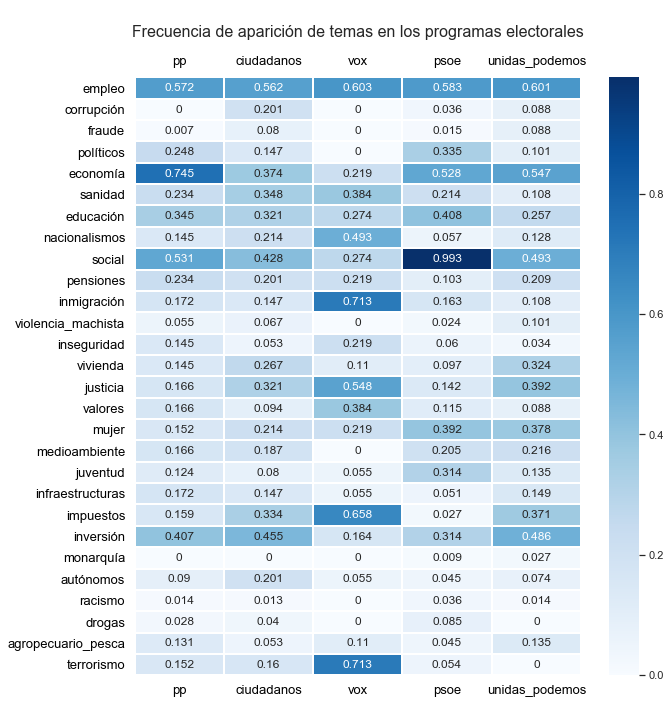

In [29]:
plt.figure(figsize=(10,11))
ax = sns.heatmap(df_rel.T.round(3), annot=True, fmt='g', cmap='Blues', linecolor='white', linewidths=1)

ax.tick_params(labelbottom=True, labeltop=True, labelsize=13, labelcolor='black')
ax.set_title('\nFrecuencia de aparición de temas en los programas electorales\n\n', 
             fontsize=16);

Creamos una gráfica de barras horizontales agrupadas por temática, con el fin de poder ver el peso de cada problema, y a la vez comparar los 5 partidos en cada uno de ellos (algo posible gracias a la normalización previa). El orden de los problemas viene de la importancia reflejada en la encuesta del CIS (de menor a mayor). Lo que esperaríamos encontrar es que el tamaño de las barras fuera creciendo según vamos avanzando, aunque viendo el dataframe ya sabemos que no se va a cumplir.

Usamos la función `plot()` de `pandas`:

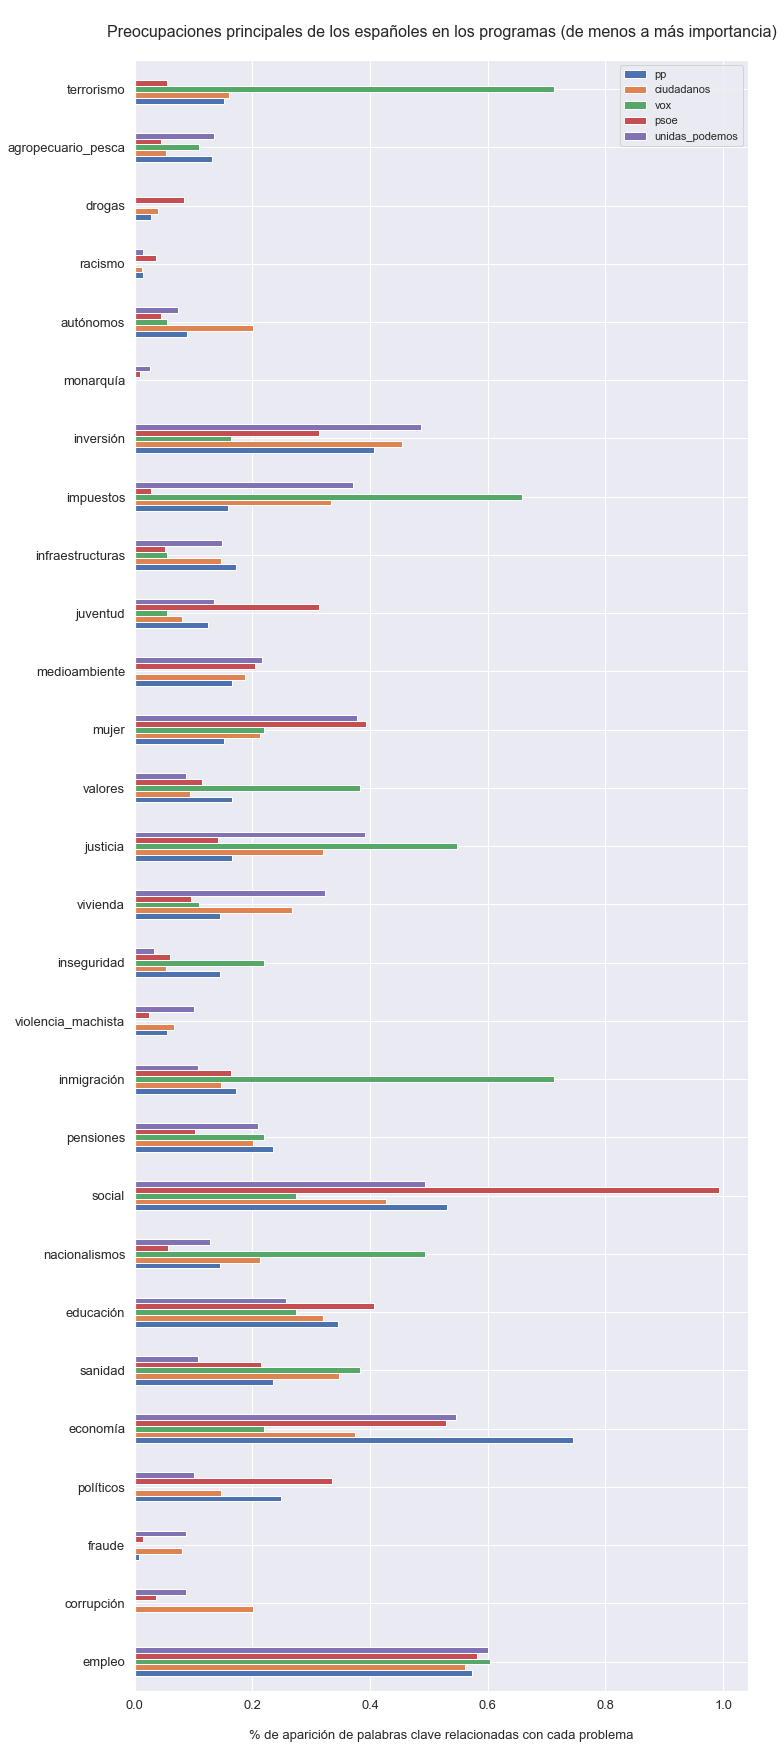

In [30]:
ax = df_rel.T.plot(kind='barh', figsize=(11,30), fontsize=13)

ax.set_title('\nPreocupaciones principales de los españoles en los programas (de menos a más importancia)\n', 
             fontsize=16)
ax.set_xlabel("\n% de aparición de palabras clave relacionadas con cada problema\n", fontsize=13);

**¿Llamativo?**

Desde luego que no parece seguir el patrón de preocupaciones de los votantes, sobre todo en temas de corrupción y fraude (posición 2); donde sólo los programas de Ciudadanos y Unidas Podemos parecen incidir. El resto pasa de puntillas o directamente no pasa (si la curiosidad aprieta, aquí habría que acudir directamente a los programas).

Podemos observar alguna cosa más:
* De la comparativa entre partidos vemos que el programa de Vox es el más diferente al resto, con diferencia.
* El PSOE parece haber hecho bastante hincapié en temas sociales, además de alinearse con mujeres y jóvenes.
* Ciudadanos es el partido que más se centra en los autónomos.
* Unidas Podemos es el que más parte de su programa dedica a inversión, a vivienda, al sector agropecuario o al medioambiente.
* El programa del PP sólo destaca, y no mucho, en materia de economía e infraestructuras.

Quizá después de este somero análisis no sabremos las medidas que explica cada programa, pero igual nos ha ayudado a saber los que no necesitamos ni abrir.

Un programa electoral es el lugar donde cada partido debería plasmar todas sus intenciones, aunque cada vez parece que se les da menos importancia (desde ambas partes).

# Otros temas sensibles

Otro ejercicio que podemos hacer es buscar por temas concretos que en realidad preocupan a la población aunque no aparezcan reflejados en las encuestas del CIS:

In [31]:
problems = {'rural': ['rural', 'rurales', 'despoblación'],
            'cultura': ['cultura', 'cine', 'música', 'teatro'],
            'lgtbi': ['lgtb', 'lgtbi', 'lesbianas', 'homosexuales', 'homosexual', 'transgénero', 'gay', 
                      'gays', 'homofobia'],
            'animales': ['animales', 'animalista', 'animalistas', 'mascotas'],
            'toros': ['tauromaquia', 'toro', 'toros', 'taurino', 'taurinos', 'corrida', 'corridas'],
            'iglesia': ['iglesia', 'católicos', 'católica', 'católico', 'cristianos', 'cristiano',
                        'cristiandad', 'sectas', 'procesiones'],
            'eutanasia': ['eutanasia'],
            'ong': ['ong', 'ongs'],
            'aborto': ['aborto', 'abortar']
            }

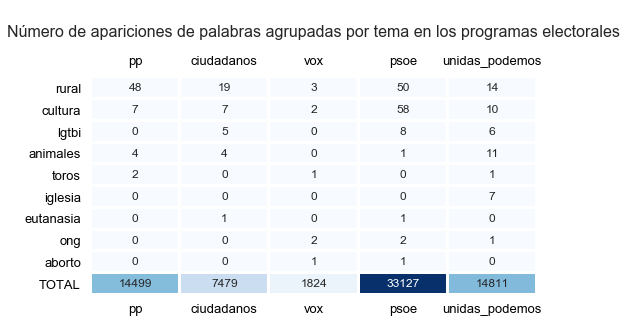

In [32]:
df = build_problems_df(problems)

plt.figure(figsize=(8,4))
ax = sns.heatmap(df.T, annot=True, fmt='d', cmap='Blues', cbar=False, linecolor='white', linewidths=2)

ax.tick_params(labelbottom=True, labeltop=True, labelsize=13, labelcolor='black')
ax.set_title('\nNúmero de apariciones de palabras agrupadas por tema en los programas electorales\n\n', 
             fontsize=16);

Algunos puntos interesantes:
* Los problemas del mundo rural parecen ser importantes para todos los partidos (menos mal).
* PP y Vox parecen no hacer ninguna referencia al colectivo LGTBi.
* El programa de Unidas Podemos parece ser el único que habla de la iglesia.

Aquí podríamos entretenernos mucho tiempo :)

# Líneas futuras de trabajo

Se podría ampliar este análisis en varias direcciones:
* Comparativa con los programas electorales de las anteriores elecciones generales, para ver cómo han evolucionado. 
* Análisis de sentimiento. No sabemos si se habla de un determinado tema en una dirección o en la contraria.
* Uso de bigramas y trigramas para poder realizar un mejor estudio de los programas.
* Análisis de discursos electorales.
* Creación de una API para hacer búsquedas en los programas

P.D.- Es una pena que los programas electorales se publiquen tan tarde y no haya tiempo para mucho más. ¡Para las próximas elecciones estaremos preparados con antelación!

# Referencias
* [tika-python](https://github.com/chrismattmann/tika-python)
* [pdftotext](https://en.wikipedia.org/wiki/Pdftotext)
* [textract](https://textract.readthedocs.io/en/latest/)
* [beautiful soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
* [stop-words](https://pypi.org/project/stop-words/)
* [word_cloud](https://amueller.github.io/word_cloud/)
* [plotly_express](https://medium.com/@plotlygraphs/introducing-plotly-express-808df010143d)
* [seaborn](https://seaborn.pydata.org/)
* [pandas visualization](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html)